The paper, Explaining and Harnessing Adversarial Examples, describes a function known as Fast Gradient Sign Method, or FGSM, for generating adversarial noise: <br>
η=ϵ sign(∇ₓ J(θ,x,y)) <br>
<ol>
    <li>We take the gradient of the cost function with respect to the model’s input, output, and weights. This operation is expressed in math by ∇ₓJ(θ, x, y).<br> J(θ, x, y) is the mathematical representation of the loss of the model, where θ is the parameters of the model, x, is the input to the model, and y is the output of the model.</li>
<li>We take the sign of each term in the gradient, reducing it to a matrix of -1s, 0s, and 1s.
Lastly, we scale down the perturbations, by multiplying them by some small float, ϵ.<br>
    This results in η, which is the variable used to represent the adversarial perturbations.</li></ol>

In [34]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist,cifar10

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #load data

In [9]:
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [6]:
# Process the data, normalize it, reshape it, and one-hot-encode the labels

In [3]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [5]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0334 - accuracy: 0.7476 - val_loss: 0.0061 - val_accuracy: 0.9598
Epoch 2/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0097 - accuracy: 0.9365 - val_loss: 0.0051 - val_accuracy: 0.9656
Epoch 3/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0078 - accuracy: 0.9501 - val_loss: 0.0040 - val_accuracy: 0.9734
Epoch 4/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0064 - accuracy: 0.9594 - val_loss: 0.0042 - val_accuracy: 0.9722
Epoch 5/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0059 - accuracy: 0.9621 - val_loss: 0.0037 - val_accuracy: 0.9770
Epoch 6/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0052 - accuracy: 0.9670 - val_loss: 0.0037 - val_accuracy: 0.9771
Epoch 7/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0048 - accuracy: 0.9697 - val_loss: 0.0035 - val_ac

In [8]:
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test))

313/313 [==============================] - 1s 3ms/step - loss: 0.0031 - accuracy: 0.9812
Base accuracy on regular images: [0.0030926421750336885, 0.9811999797821045]


In [10]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:   # J(θ, x, y)
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image) # ∇ₓ
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [29]:
# creating an adversarial image
image = x_train[15]
image_label = y_train[15]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy() # .numpy() converts the EagerTensor object into a numpy array
adversarial = image + perturbations * 0.1

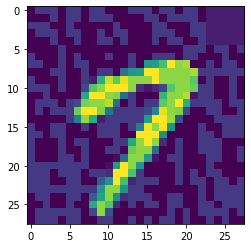

Truth: seven
Prediction: nine


In [30]:
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()
print('Truth:',labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print('Prediction:',labels[model.predict(adversarial).argmax()])

In [31]:
# original model predicts 7
# adversarial example generates 9

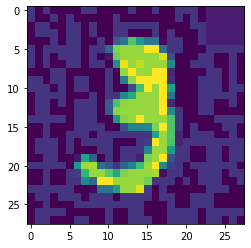

Truth: three
Prediction: one


In [28]:
# example 2 
image = x_train[10]
image_label = y_train[10]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy() # .numpy() converts the EagerTensor object into a numpy array
adversarial = image + perturbations * 0.09
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()
print('Truth:',labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print('Prediction:',labels[model.predict(adversarial).argmax()])